<a href="https://colab.research.google.com/github/lucadonnoh/progetto-deblur/blob/main/Progetto_Deblur_CN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Progetto Deblur**

---

Un'azienda vuole commercializzare un dispositivo di acquisizione immagini, del quale si sa che acquisisce con rumore Gaussiano additivo e sfocatura Gaussiana.
Il modello è quindi:

\begin{align*}
    b = A x_{true} + \eta
\end{align*}

Dove $A \in \mathbb{R}^{mn}$ è la matrice di sfocamento, $\eta \sim \mathcal{N}(0, \sigma^2)$ rumore additivo con varianza $\sigma^2$ incognita, $b \in \mathbb{R}^{mn}$ è la vettorizzazione dell'immagine corrotta (acquisita) $B \in \mathbb{R}^{m \times n}$, $x_{true} \in \mathbb{R}^{mn}$ è la vettorizzazione dell'immagine originale $X_{true} \in \mathbb{R}^{m \times n}$.


1. Dopo aver importato le librerie necessarie, assegnare ad una variabile $X$ l'immagine $\texttt{cameraman}$, ottenibile tramite la libreria $\texttt{skimage.data}$ con il nome di $\texttt{camera()}$, effettuarne il $\texttt{reshape}$ e assegnarlo alla variabile $x$.

2. Tramite la funzione $\texttt{skimage.filters.gaussian}$ aggiungere sfocatura Gaussiana ad $X$ per ottenere $X_{blur}$, che rappresenta il reshape ad immagine di $x_{blur} = A x_{true}$, con $A$ matrice di sfocatura.

3. Caricare su una variabile $\eta$, della stessa dimensione di $X_{true}$, una realizzazione di rumore gaussiano con varianza $\sigma = 0.1$ (fare riferimento alle slides per la formula). 
Utilizzare $\eta$ per corrompere l'immagine $X_{blur}$ e calcolare $B = X_{blur} + \eta$. \\
Visualizzare i risultati ottenuti.

In [24]:
def gkern(kernlen, nsig):
  """
  Genera un kernel per la realizzazione di un filtro di sfocatura Gaussiana.

  Input ->
  kernlen: diametro della sfocatura gaussiana.
  nsig:    varianza della sfocatura. Più basso, più sfoca.

  Output -> Kernel Gaussiano di dimensione (kernlen+1) x (kernlen+1) e varianza nsig.
  """
  import scipy.stats as st

  x = np.linspace(-nsig, nsig, kernlen+1)
  kern1d = np.diff(st.norm.cdf(x))
  kern2d = np.outer(kern1d, kern1d)
  return kern2d/kern2d.sum()

def A(x, d=7, sigma=0.5):
  """
  Esegue il prodotto Ax, dove A è la matrice di sfocamento (che, per aumentare l'efficienza, non viene memorizzata).
  
  Input ->
  x:     Immagine di dimensione m x n, che si vuole sfocare.
  d:     Diametro della sfocatura Gaussiana.
  sigma: Varianza della sfocatura Gaussiana.
  
  Output -> Immagine di dimensione m x n, sfocata.
  """
  from scipy.signal import convolve2d
  from numpy import fft
  m, n = x.shape

  K_ext = np.zeros((m, n)) 
  K_ext[:d, :d] = gkern(d, sigma)
  K_ext = fft.fft2(K_ext)
  x = fft.fft2(x)

  return np.real(fft.ifft2(K_ext * x))

def AT(x, d=7, sigma=0.5):
  """
  Esegue il prodotto A^T x, dove A è la matrice di sfocamento (che, per aumentare l'efficienza, non viene memorizzata).
  
  Input ->
  x:     Immagine di dimensione m x n, che si vuole sfocare.
  d:     Diametro della sfocatura Gaussiana.
  sigma: Varianza della sfocatura Gaussiana.
  
  Output -> Immagine di dimensione m x n, sfocata.
  """
  from scipy.signal import convolve2d
  from numpy import fft
  m, n = x.shape

  K_ext = np.zeros((m, n))
  K_ext[:d, :d] = gkern(d, sigma)
  K_ext = fft.fft2(K_ext)
  x = fft.fft2(x)

  return np.real(fft.ifft2(np.conj(K_ext) * x))

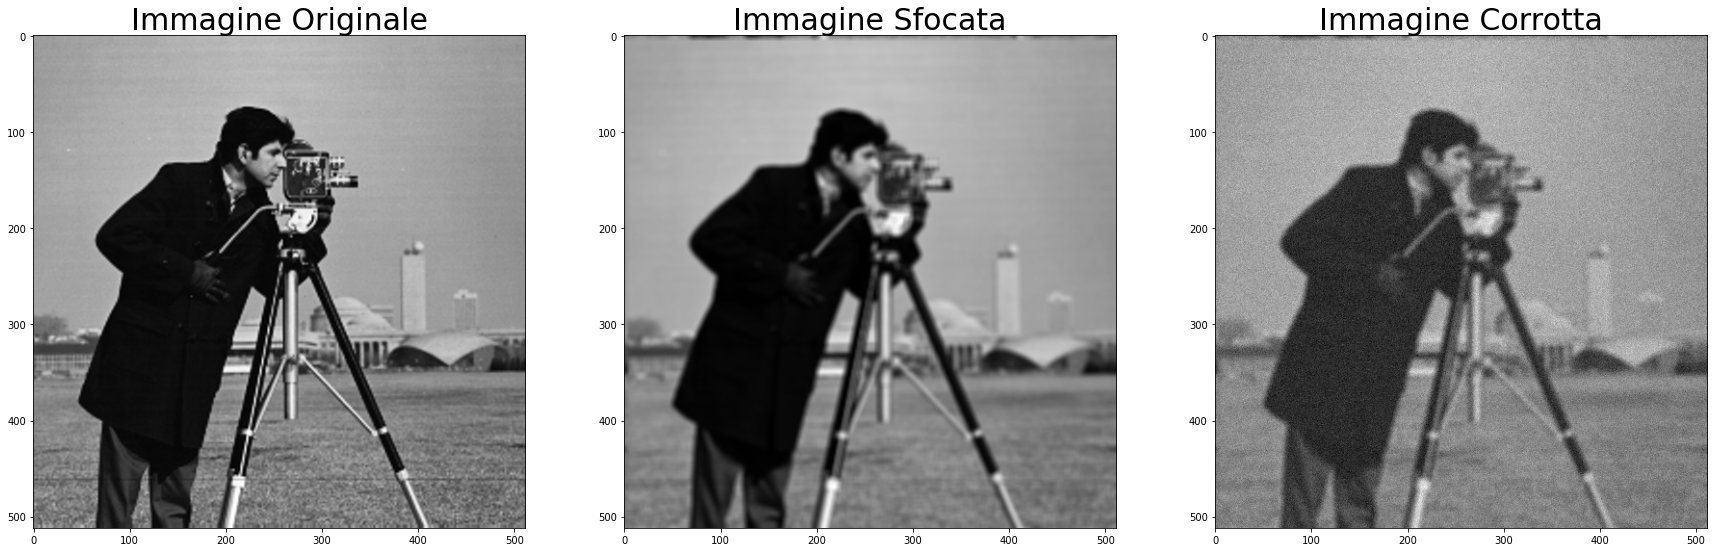

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, filters

# 1
X = data.camera()
m, n = X.shape
x = X.reshape(m*n) # array m*n


# 2
X_blur = A(X) # matrice
x_blur = X_blur.reshape(m*n) # array


# 3
# Generiamo il rumore eta
sigma = 0.1 # Varianza del rumore
eta = np.random.normal(size=X_blur.shape) # random gaussian distribution
eta /= np.linalg.norm(eta, 'fro') # norma di frobenius
eta *= sigma * np.linalg.norm(X_blur,'fro')

# Aggiungiamo il rumore all'immagine sfocata
B = X_blur + eta
b = B.reshape(m*n)

# Visualizziamo i risultati
plt.figure(figsize=(30, 10))

ax1 = plt.subplot(1, 3, 1)
ax1.imshow(X, cmap='gray')
plt.title('Immagine Originale', fontsize=30)

ax2 = plt.subplot(1, 3, 2)
ax2.imshow(X_blur, cmap='gray')
plt.title('Immagine Sfocata', fontsize=30)

ax3 = plt.subplot(1, 3, 3)
ax3.imshow(B, cmap='gray')
plt.title('Immagine Corrotta', fontsize=30)

plt.show()

Il problema di ricostruire l'immagine originale partendo dalla sua corruzione $b$, si può riscrivere come un problema di ottimizzazione

\begin{align}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 \hspace{2cm} (1)
\end{align}

4. Risolvere il problema (1) utilizzando l'algoritmo di discesa del gradiente con scelta del passo tramite backtracking, ricordando che, se 
\begin{align*}
  f(x) = \frac{1}{2} ||Ax - b||_2^2, \hspace{10px} \nabla f(x) = A^T(Ax - b)
\end{align*}
E chiamare la soluzione ottenuta $x_{naive}$.

5. Modificare l'algoritmo precedente a far restituire l'errore tra l'immagine ricostruita al passo $k$ e l'immagine originale, per ogni $k$. Visualizzare il grafico dell'errore, e individuare per quale valore di $k$ si ha semiconvergenza. Per tale valore, calcolare l'immagine ricostruita e chiamarla $x_{trunc}$.

In [26]:
# 4 - 5 
#Modificare l'algoritmo è stato interpretato come "sovrascrivere il precedente"

def f(x, b): #
  return 0.5*(np.linalg.norm(A(x)-b))**2

def grad_f(x, b):
  return AT(A(x)-b)

def next_step(x, b, f, grad):
  alpha = 0.5
  rho = 0.5
  c1 = 0.25
  k = 0

  while f(x-alpha*grad, b) > f(x, b) - alpha * c1 * np.linalg.norm(grad, 'fro') ** 2:
    alpha *= rho
    k += 1
  
  return alpha;

def minimize(x0, x_true, b, maxit, abstop):
  x = x0
  grad = grad_f(x, b)
  err = np.zeros(maxit) #errore alla k-esima iterazione

  k = 0
  while (np.linalg.norm(grad) > abstop) and (k < maxit):
    x = x + next_step(x, b, f, grad) * (-grad) # x + passo*direzione (-gradiente ovvero massima decrescita)
    grad = grad_f(x, b)
    err[k]  = np.linalg.norm(x_true - x)  #distanza con la norma2, prima fa la differenza membro a membro fra matrici poi ne calcola la norma2
    k += 1
    print(".", end='')

  err = err[0:k]  #l'ultima iterazione è esclusa perchè l'estremo destro viene escluso
  return(x, k, err)


..................................................
 [12044.63098969 10926.74922811 10313.13296097  9948.41368818
  9717.52969919  9565.67289212  9464.56889221  9398.3724464
  9357.51782258  9335.85809589  9329.23564021  9334.71729905
  9350.15973261  9373.94939092  9404.8400846   9441.8477433
  9484.18006035  9531.18816465  9582.33262059  9637.15899352
  9695.27994996  9756.36191441  9820.11496314  9886.28505667
  9954.64798802 10025.00460838 10097.17701591 10171.00548037
 10246.34593602 10323.06791835 10401.052851   10480.19261165
 10560.38832202 10641.54931966 10723.59227823 10806.44045009
 10890.0230102  10974.27448485 11059.13425137 11144.54609818
 11230.45783584 11316.82095205 11403.59030406 11490.72384376
 11578.18237087 11665.9293108  11753.93051396 11842.15407414
 11930.57016351 12019.15088242]


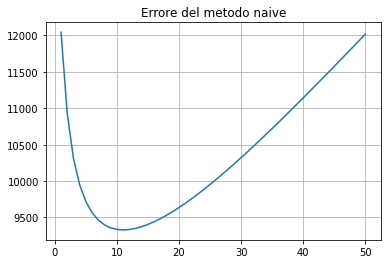

...........[9329.23564021]


In [27]:
def plot( iters, error, title): 
  err_iteration = np.linspace(1, iters, error.size)
  plt.plot(err_iteration, error)
  plt.title(title)
  plt.grid()
  plt.show()

def find_x(error):
  return np.where(error == np.amin(error))[0]

MAXITERATIONS=50
ABSOLUTE_STOP=1.e-5

x_naive, ite_naive, err_naive = minimize(B, X, B, MAXITERATIONS, ABSOLUTE_STOP) #anche se nelle funzioni viene utilizzato 'x' viene passata 'X' ovvero la matrice dell'immagine
print("\n", err_naive)
plot(ite_naive, err_naive,"Errore del metodo naive")

X_trunc_index = find_x(err_naive)
X_trunc,_,erroredio= minimize(B,X,B,X_trunc_index+1, ABSOLUTE_STOP)
print(err_naive[X_trunc_index])

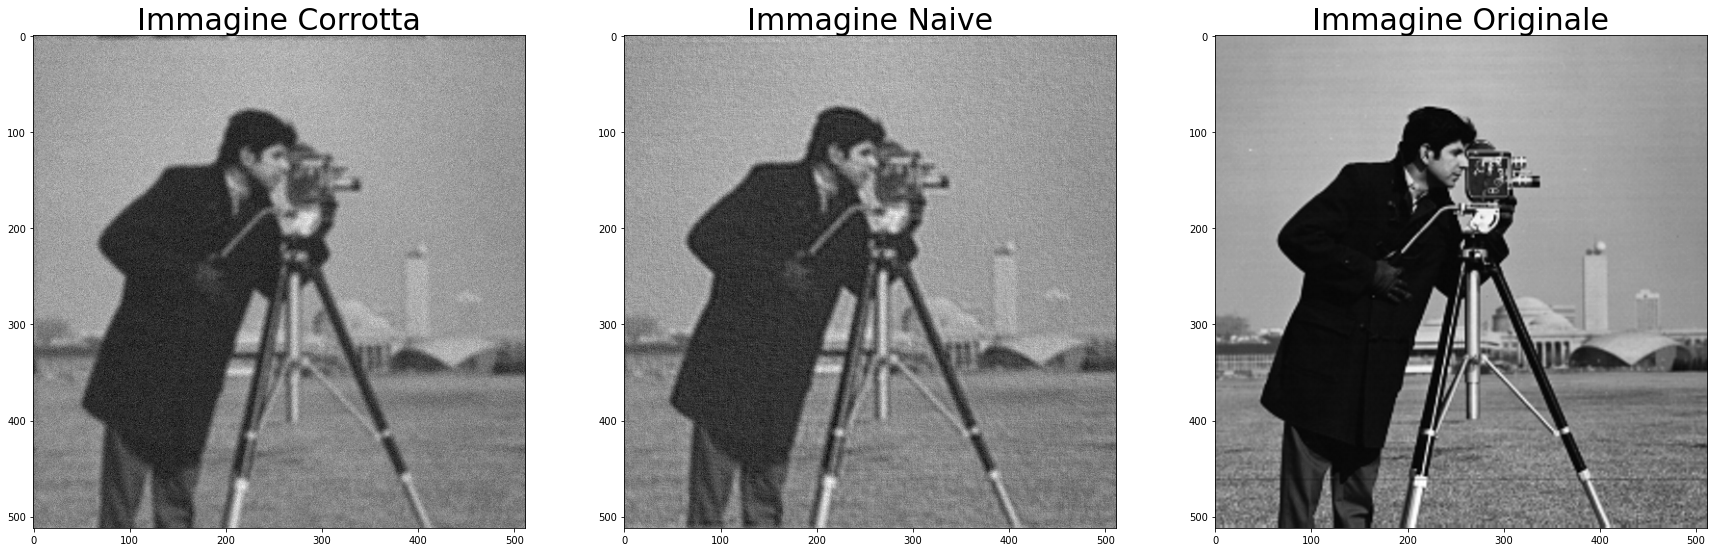

In [28]:
#Plottiamo il risultato
plt.figure(figsize=(30, 10))

fig1 = plt.subplot(1, 3, 1)
fig1.imshow(B, cmap='gray')
plt.title('Immagine Corrotta', fontsize=30)

fig2 = plt.subplot(1, 3, 2)
fig2.imshow(X_trunc, cmap='gray')
plt.title('Immagine Naive', fontsize=30)

fig3 = plt.subplot(1, 3, 3)
fig3.imshow(X, cmap='gray')
plt.title('Immagine Originale', fontsize=30)

plt.show()

Per risolvere la semiconvergenza, si introduce il problema regolarizzato

\begin{align*}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2 \hspace{2cm} (2)
\end{align*}

con $\lambda > 0$ parametro di regolarizzazione.

6. Sfruttando il fatto che, se
\begin{align*}
f(x) = \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2, \hspace{10px} \nabla f(x) = A^T(Ax - b) + \lambda x
\end{align*}
Risolvere il problema (2) utilizzando l'algoritmo precedente per diversi valori di $\lambda$, e stimare il valore ottimale di $\lambda$ che minimizzi l'errore tra l'immagine ricostruita e l'immagine originale (metodo euristico per il parametro di regolarizzazione). Chiamare $x_{\lambda}$ tale soluzione. \\

7. Stimare il valore ottimale di $\lambda$ tramite principio di discrepanza, ovvero scegliere il più grande $\lambda$ tale che
\begin{align*}
  ||A x_\lambda - b||_2^2 \leq ||\eta||_2^2
\end{align*}
Dove $\eta$ è il rumore. Chiamare $x_\lambda^{disc}$ la soluzione ottenuta dal $\lambda$ calcolato con principio di discrepanza.
 

In [29]:
def f_reg(x, b, lamb):
  return 0.5*(np.linalg.norm(A(x)-b))**2 + 0.5*lamb*np.linalg.norm(x)**2

def grad_f_reg(x, b, lamb):
  return AT(A(x)-b) + lamb*x

def next_step_reg(x, b, f, grad, lamb):
  alpha = 1.1
  rho = 0.5
  c1 = 0.25
  k = 0

  while f_reg(x-alpha*grad, b, lamb) > f_reg(x, b, lamb) - alpha * c1 * np.linalg.norm(grad, 'fro') ** 2:
    alpha *= rho
    k += 1
  
  return alpha;

def minimize_reg(x0, x_true, b, lamb, maxit, abstop):
  x = x0
  grad = grad_f_reg(x, b, lamb)
  err = np.zeros(maxit) #errore alla k-esima iterazione

  k = 0
  while (np.linalg.norm(grad) > abstop) and (k < maxit):
    x = x + next_step_reg(x, b, f, grad, lamb) * (-grad) # x + passo*direzione (-gradiente ovvero massima decrescita)
    grad = grad_f_reg(x, b, lamb)
    err[k]  = np.linalg.norm(x_true - x)  #distanza con la norma2, prima fa la differenza membro a membro fra matrici poi ne calcola la norma2
                                          #TODO: in teoria si potrebbe trasformare entrambi le matrici in vettori e poi farne la distanza ma ha senso? 
    k += 1
    #print(".", end='')

  err = err[:k]  #l'ultima iterazione è esclusa perchè l'estremo destro viene escluso
  return(x, k, err)


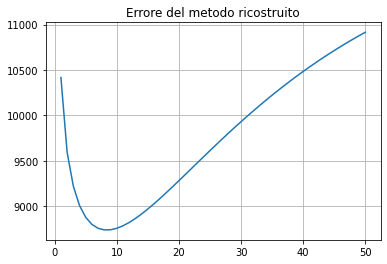

[8741.29999278]


In [30]:
def lambottimale(x, b, max):
  lamb=0.00000001
  k=0
  x,_,_ = minimize_reg(B,X,B,lamb, max, ABSOLUTE_STOP)
  rat = 1.1
  while np.linalg.norm(A(x)-b)**2 <= np.linalg.norm(eta)**2:
    lamb *= rat
    x,_,_ = minimize_reg(B,X,B,lamb, max, ABSOLUTE_STOP)
    k+=1
    print(",", end='')
  print("it: ", k)
  return lamb/rat

lamb = 0.02155582137126536 #lambda in modo euristico

(x_reg, ite_reg, err_reg) = minimize_reg(B, X, B, lamb, MAXITERATIONS, ABSOLUTE_STOP) #anche se nelle funzioni viene utilizzato 'x' viene passata 'X' ovvero la matrice dell'immagine
#print("\n", err_reg)
plot(ite_reg, err_reg,"Errore del metodo ricostruito")

X_reg_index_rec = find_x(err_reg)
print(err_reg[X_reg_index_rec])
X_lambda,_,_= minimize_reg(B, X, B, lamb, X_reg_index_rec+1, ABSOLUTE_STOP)



 [10416.44272483  9593.89713225  9222.32896774  9008.341297
  8879.0390703   8801.36143314  8758.70446017  8741.29999278
  8742.86709494  8759.06889635  8786.75170401  8823.53106602
  8867.55059264  8917.33272547  8971.68162909  9029.6171961
  9090.32848153  9153.13976092  9217.48508662  9282.88875138
  9348.9499787   9415.33071749  9481.74577035  9547.9547125
  9613.75520995  9678.97744789  9743.47945232  9807.14313836
  9869.87095577  9931.58302925  9992.2147118  10051.71448488
 10110.0421514  10167.16727699 10223.06784276 10277.72907873
 10331.14245216 10383.30478899 10434.21751004 10483.8859662
 10532.31885944 10579.52773811 10625.52655678 10670.33129228
 10713.95960856 10756.43056432 10797.76435782 10837.98210422
 10877.10564154 10915.15736146]


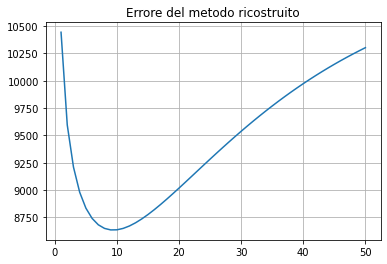

[8634.80309783]


In [31]:
lamb_disc = 0.025625815225418787 #lamda tramite condizione discrepanza

x0 = np.zeros(X.shape) # immagine ricostruita al passo 0
(X_reg2, ite_reg2, err_reg2) = minimize_reg(B, X, B, lamb_disc, MAXITERATIONS, ABSOLUTE_STOP) #anche se nelle funzioni viene utilizzato 'x' viene passata 'X' ovvero la matrice dell'immagine
print("\n", err_reg)
plot(ite_reg2, err_reg2,"Errore del metodo ricostruito")

X_reg_index2 = find_x(err_reg2)
print(err_reg2[X_reg_index2])
X_lambda_disc,_,_= minimize_reg(B, X, B, lamb_disc, X_reg_index+1, ABSOLUTE_STOP)

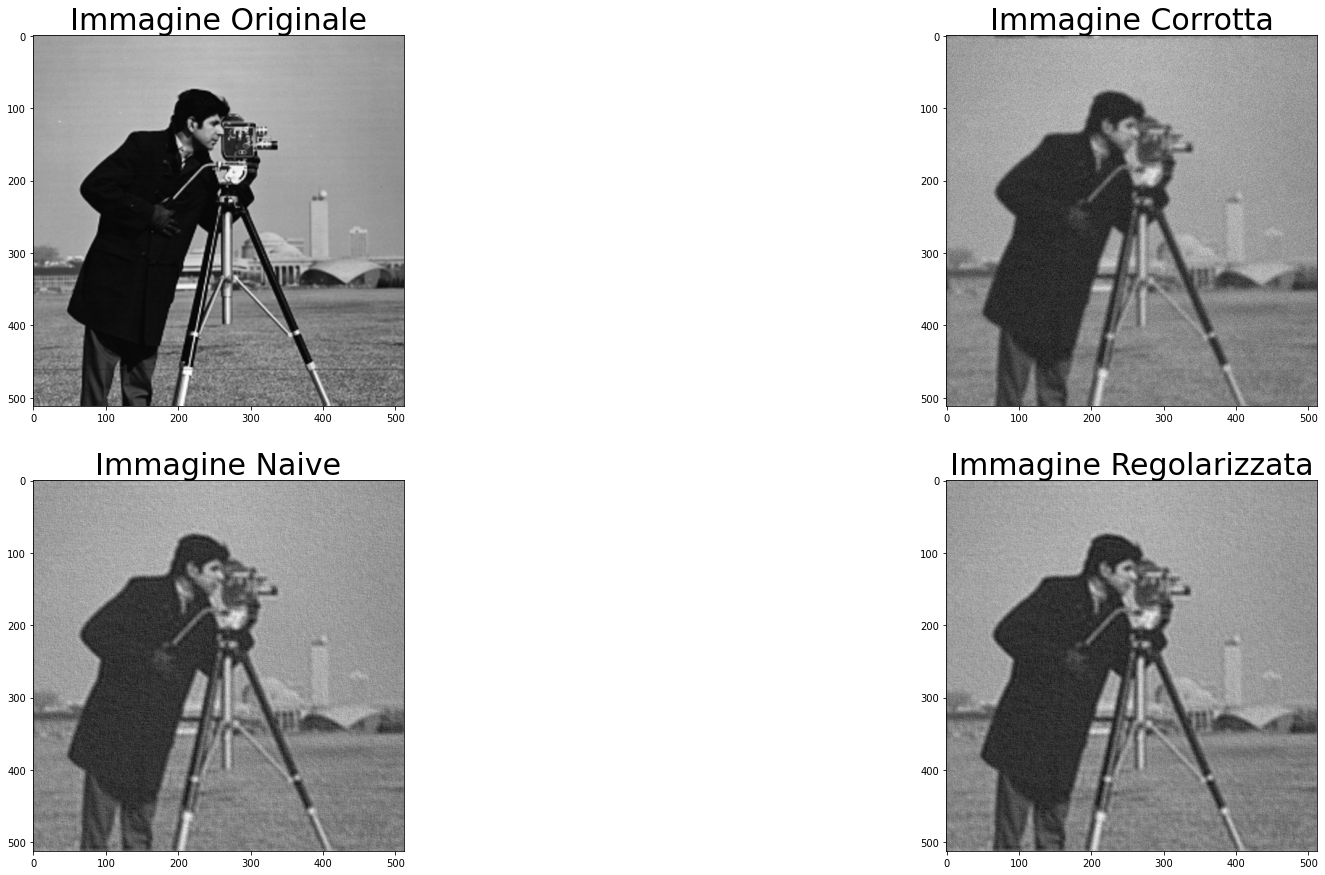

In [32]:
#Plottiamo il risultato
plt.figure(figsize=(30, 15))

fig0 = plt.subplot(2, 2, 2)
fig0.imshow(B, cmap='gray')
plt.title('Immagine Corrotta', fontsize=30)

fig1 = plt.subplot(2, 2, 3)
fig1.imshow(X_trunc, cmap='gray')
plt.title('Immagine Naive', fontsize=30)

fig2 = plt.subplot(2, 2, 4)
fig2.imshow(X_lambda_disc, cmap='gray')
plt.title('Immagine Regolarizzata', fontsize=30)

fig3 = plt.subplot(2, 2, 1)
fig3.imshow(X, cmap='gray')
plt.title('Immagine Originale', fontsize=30)

plt.show()

8. Ripetere quanto fatto nel punto 6, utilizzando la norma 1 come regolarizzatore, ovvero:
\begin{align*}
    x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \lambda ||x||_1 \hspace{2cm} (3)
\end{align*}
Dove la funzione obiettivo ha gradiente
\begin{align*}
  A^T(Ax - b) + \lambda \hspace{2px} sign(x)
\end{align*}

In [33]:
def f_reg_1(x, b, lamb): #
  return 0.5*(np.linalg.norm(A(x)-b))**2 + lamb*np.linalg.norm(x, 1)

def grad_f_reg_1(x, b, lamb):
  return AT(A(x)-b) + lamb*np.sign(x)

def next_step_reg_1(x, b, f, grad, lamb):
  alpha = 1.1
  rho = 0.5
  c1 = 0.25
  k = 0

  while f_reg_1(x-alpha*grad, b, lamb) > f_reg_1(x, b, lamb) - alpha * c1 * np.linalg.norm(grad, 'fro') ** 2:
    alpha *= rho
    k += 1
  
  return alpha;

def minimize_reg_1(x0, x_true, b, lamb, maxit, abstop):
  x = x0
  grad = grad_f_reg_1(x, b, lamb)
  err = np.zeros(maxit) #errore alla k-esima iterazione

  k = 0
  while (np.linalg.norm(grad) > abstop) and (k < maxit):
    x = x + next_step_reg_1(x, b, f, grad, lamb) * (-grad) # x + passo*direzione (-gradiente ovvero massima decrescita)
    grad = grad_f_reg_1(x, b, lamb)
    err[k]  = np.linalg.norm(x_true - x)  #distanza con la norma2, prima fa la differenza membro a membro fra matrici poi ne calcola la norma2
                                          #TODO: in teoria si potrebbe trasformare entrambi le matrici in vettori e poi farne la distanza ma ha senso? 
    k += 1
    print(".", end='')

  err = err[:k]  #l'ultima iterazione è esclusa perchè l'estremo destro viene escluso
  return(x, k, err)

..................................................
 [10419.04360609  9709.52007034  9434.48007145  9326.62807194
  9306.08128638  9339.22475786  9408.87361028  9505.02277214
  9621.26364043  9753.19439637  9897.62875131 10052.16307399
 10214.93149507 10384.44609008 10559.50174798 10739.10447089
 10922.42956595 11108.78448582 11297.57692365 11488.31148962
 11680.56012845 11873.95535936 12068.17746101 12262.95552012
 12458.05063942 12653.26031623 12848.40297182 13043.32555901
 13237.89501749 13431.99326704 13625.51993589 13818.38618817
 14010.52004019 14201.85509553 14392.33556959 14581.91431082
 14770.54987554 14958.20649287 15144.85745827 15330.47872293
 15515.05130621 15698.55829292 15880.98826599 16062.33135229
 16242.58116687 16421.72986389 16599.77631185 16776.72180734
 16952.56675941 17127.31375553]


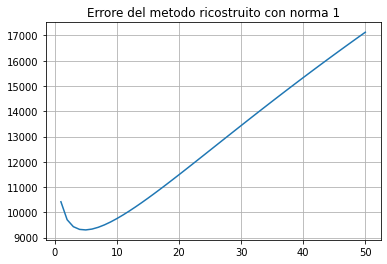

[9306.08128638]
.....

In [34]:
#Punto 8,  norma 1

lamb_1 = 0.025625815225418787 #lamda tramite condizione discrepanza

(x_rec_1, ite_rec_1, err_reg_1) = minimize_reg_1(B, X, B, lamb, MAXITERATIONS, ABSOLUTE_STOP) #anche se nelle funzioni viene utilizzato 'x' viene passata 'X' ovvero la matrice dell'immagine
print("\n", err_reg_1)
plot(ite_rec_1, err_reg_1,"Errore del metodo ricostruito con norma 1")

X_reg_index_1 = find_x(err_reg_1)
print(err_reg_1[X_reg_index_1])
X_lambda_1,_,_= minimize_reg_1(B, X, B, lamb_1, X_reg_index_1+1, ABSOLUTE_STOP)

9. ($\textit{facoltativo}$) Ripetere quanto fatto nei punti 6 e 8, utilizzando una norma mista come regolarizzatore, ovvero:
\begin{align*}
    x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2 + \mu ||x||_1 \hspace{2cm} (4)
\end{align*}

In [35]:
#TODO: va definito mu
#TODO: va anche trovato il gradiente, davide dice che dobbiam esser bravi a trovarcelo

def f_reg_mista(x, b, lamb, mu): 
  return 0.5*(np.linalg.norm(A(x)-b))**2 + 0.5*lamb*np.linalg.norm(x)**2 + mu*np.linalg.norm(x,1)

def grad_f_reg_mista(x, b, lamb, mu):
  return AT(A(x)-b) + lamb*x +  mu*np.sign(x)

def next_step_reg_mista(x, b, f, grad, lamb, mu):
  alpha = 1.1
  rho = 0.5
  c1 = 0.25
  k = 0

  while f_reg_mista(x-alpha*grad, b, lamb, mu) > f_reg_mista(x, b, lamb, mu) - alpha * c1 * np.linalg.norm(grad, 'fro') ** 2:
    alpha *= rho
    k += 1
  
  return alpha;

def minimize_reg_mista(x0, x_true, b, lamb, mu, maxit, abstop):
  x = x0
  grad = grad_f_reg_mista(x, b, lamb, mu)
  err = np.zeros(maxit) #errore alla k-esima iterazione

  k = 0
  while (np.linalg.norm(grad) > abstop) and (k < maxit):
    x = x + next_step_reg_mista(x, b, f, grad, lamb, mu) * (-grad) # x + passo*direzione (-gradiente ovvero massima decrescita)
    grad = grad_f_reg_mista(x, b, lamb, mu)
    err[k]  = np.linalg.norm(x_true - x)  #distanza con la norma2, prima fa la differenza membro a membro fra matrici poi ne calcola la norma2
                                          #TODO: in teoria si potrebbe trasformare entrambi le matrici in vettori e poi farne la distanza ma ha senso? 
    k += 1
    print(".", end='')

  err = err[:k]  #l'ultima iterazione è esclusa perchè l'estremo destro viene escluso
  return(x, k, err)

..................................................
 [10417.67731727  9593.7883794   9221.34718887  9006.39498557
  8876.14074415  8797.51716989  8753.93330741  8735.62240494
  8736.30118283  8751.63152489  8778.45904481  8814.3993688
  8857.59504938  8906.56993591  8960.12688105  9017.28542936
  9077.23461862  9139.29810569  9202.90980949  9267.59139647
  9332.94436733  9398.62955218  9464.36176748  9529.89999518
  9595.04212805  9659.6179185   9723.48233827  9786.5198773
  9848.63472178  9909.74389034  9969.78276903 10028.70256253
 10086.46204008 10143.029312   10198.38151713 10252.50507305
 10305.39111297 10357.03718929 10407.44422811 10456.61549419
 10504.55912891 10551.28696989 10596.8145863  10641.15696343
 10684.33134477 10726.3585832  10767.25583347 10807.04680859
 10845.74991361 10883.39038388]


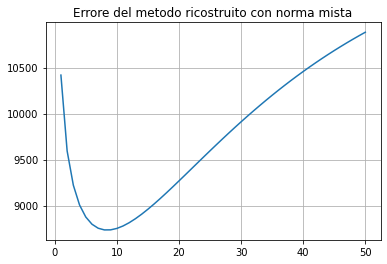

[8735.62240494]
........

In [36]:
#Punto 9,  norma mista

lamb = 0.02155582137126536 #lamda tramite condizione discrepanza
mu = 0.025625815225418787

(x_rec_mista, ite_rec_mista, err_reg_mista) = minimize_reg_mista(B, X, B, lamb, mu, MAXITERATIONS, ABSOLUTE_STOP) #anche se nelle funzioni viene utilizzato 'x' viene passata 'X' ovvero la matrice dell'immagine
print("\n", err_reg_mista)
plot(ite_rec_mista, err_reg_mista,"Errore del metodo ricostruito con norma mista")

X_reg_mista = find_x(err_reg_mista)
print(err_reg_mista[X_reg_mista])
X_lambda_mista,_,_= minimize_reg_mista(B, X, B, lamb, mu, X_reg_mista+1, ABSOLUTE_STOP)

---

# Analisi dei risultati

---

Per ognuna delle soluzioni trovate, calcolare:

*   Errore relativo rispetto alla soluzione esatta $x_{true}$.
*   PSNR (Peak Signal to Noise Ratio).

Visualizzare le ricostruzioni ottenute con i vari metodi, e confrontare, sia numericamente che attraverso dei grafici, PSNR ed errore relativo ottenuti dalle ricostruzioni. Includere nel confronto, il valore delle metriche per l'immagine corrotta $b$.


Ripetere tutti i passaggi, variando il livello del rumore (controllato dalla variabile $\sigma$), i parametri del kernel di sfocamento Gaussiano, e l'immagine di test. \\
Per la scelta delle immagini di test, utilizzare immagini **in bianco e nero, a scelta**, prese da internet, che rispettino i seguenti criteri:


*   Almeno un'immagine "geometrica", ovvero con pochi dettagli e contorni netti e ben contrastati (es. QRCode, Codice a Barre, Scacchiera...).
*   Almeno un'immagine "fotografica", ovvero con molti dettagli e livelli di grigio sfocati.
*   Almeno un'immagine contenente del testo, che diventerà difficilmente leggibile dopo il processo di sfocamento.


Osservare quale metodo di ricostruzione si comporta meglio nei vari esperimenti, ricordandosi corrompere l'immagine di input sia con rumore Gaussiano che con sfocatura.

